This notebook will pull and save all orbits including:
- z=1, 1.5, 2
- separations, velocities, merger flag, time/snapshot of merger, subhalo ID 1 & 2, mass

idea: Maybe need to add nans into columns where they don’t have a separation (so that I only have to save the time/redshift/etc. once~


**goal for today:**
- save all orbits for all pairs



In [88]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

In [89]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

## Make the time, redshift, scale, snapshot conversion file

First, I need to make the sim data arrays, including the time, redshift, and scale at each snapshot. (I might have this as a data file from a long time ago)


In [90]:
if os.path.exists(f"{paths.path_data}snapshot_data.hdf5"):
    print ("file already exists")
    
else:    
    ## import simulation snapshot data 
    f = h5py.File(paths.path_data+"simulation.hdf5")

    ## initialize cosmology
    H0 = 100*f['Header'].attrs['HubbleParam']
    Omega0 = f['Header'].attrs['Omega0']
    OmegaB = f['Header'].attrs['OmegaBaryon']
    OmegaL = f['Header'].attrs['OmegaLambda']

    cosmo = FlatLambdaCDM(H0=67.74, Om0=Omega0, Ob0=OmegaB)

    ## initialize data structure
    data_dict = {}
    array_names = ["Snapshot","Redshift","Scale","Lookback Time","Age"]
    for arr in array_names:
        data_dict[arr] = []

    ## create data structure for time, redshift, scale, etc. as fxn of snapshot
    for i in range(100):
        snapshot = i
        redshift = f['Snapshots'][f'{i}']['Header'].attrs['Redshift']
        scale = 1 / (1 + redshift)
        lookback = cosmo.lookback_time(redshift).value
        age = cosmo.age(redshift).value

        data_dict['Snapshot'].append(snapshot)
        data_dict['Redshift'].append(redshift)
        data_dict['Scale'].append(scale)
        data_dict['Lookback Time'].append(lookback)
        data_dict['Age'].append(age)

    ## clsoe data file     
    f.close()

    ## store time data into hdf5 file ~

    f = h5py.File(f"{paths.path_data}snapshot_data.hdf5", 'w')

    info_dict = {"Snapshot":"Snapshot number",
                 "Redshift":"Redshift at snapshot",
                 "Scale":"Scale at snapshot",
                 "Lookback Time":"Time that has elapsed from snapshot to z=0 (in Gyr)",
                 "Age":"Age of the Universe (in Gyr)"}

    for key, val in data_dict.items():
        val = np.array(val)
        dset = f.create_dataset(f'/{key}', 
                                shape=val.shape,
                                dtype=val.dtype)
        dset.attrs[key] = info_dict[key]
        dset[:] = val

    f.close()    
    
    print("snapshot information file created")

file already exists


## Need to get data for the pairs:


first, I'm going to build the arrays of the ids, the snap of merger, and the merger flag. later i'll add in the 2D arrays of positions, velocities, etc. 

In [91]:
def save_orbitdata(red):
       
    snap_dict = {"z=1":50,"z=1.5":40,"z=2":33}
    snapshot = snap_dict[f"z={red}"]
    full_snaps = np.arange(99,0,-1)
    little_h = 0.6774
    
    if os.path.exists(f"{paths.path_data}orbitdata_{snapshot}.hdf5"):
        print ("file already exists")
    
    else:
        # ----------------------------------------------------
        # import pair data
        f = h5py.File(f"../data/lowmass_{snapshot}.hdf5", 'r')
        pairs = {}
        for key, val in f.items():
            if key != "Header":
                pairs[key] = np.array(val) 
        f.close()
        numpairs = len(pairs['Sub1 ID'])

        # ----------------------------------------------------
        # import snapshot data to convert comoving units
        snapdata = h5py.File(f"{paths.path_data}snapshot_data.hdf5","r")
        snapdata_dict={}
        for key,val in snapdata.items():
            snapdata_dict[key] = np.array(val)
        snapdata.close()

        # ----------------------------------------------------
        # initialize data structures  
        collection = {}
        id1, id2, mass1, mass2, smratio, merged_flag, snap_merged = np.zeros((7,numpairs))
        group_flag = np.zeros((numpairs,len(full_snaps)),dtype="bool")
        seps = np.zeros((numpairs,len(full_snaps)))
        vels = np.zeros((numpairs,len(full_snaps)))
        seps.fill(np.NaN)
        vels.fill(np.NaN)


        for ind in range(numpairs):
            # ----------------------------------------------------
            # get info and trees for primary and secondary
            primary_id = pairs['Sub1 ID'][ind]
            secondary_id = pairs['Sub2 ID'][ind]

            id1[ind] = primary_id
            id2[ind] = secondary_id
            mass1[ind] = pairs['Sub1 Stellar Mass'][ind]
            mass2[ind] = pairs['Sub2 Stellar Mass'][ind]
            smratio[ind] = pairs['Stellar Mass Ratio'][ind]

            treedict = {}
            for sub in [primary_id,secondary_id]:
                treedict[sub] = TraceMergerTree(snapshot=snapshot,physics="hydro",sim="TNG",subfindID=sub)

            tree_primary = treedict[primary_id].mergedbranch
            tree_secondary = treedict[secondary_id].mergedbranch

            # ----------------------------------------------------
            # check to see if halos merge
            root1 = tree_primary['RootDescendantID'][0]
            root2 = tree_secondary['RootDescendantID'][0]
            check_root = root1 == root2

            snap_mask1 = np.isin(tree_primary['SnapNum'],tree_secondary['SnapNum'])
            snap_mask2 = np.isin(tree_secondary['SnapNum'],tree_primary['SnapNum'])

            if check_root:
                merged_flag[ind] = True

                # ----------------------------------------------------
                # identify the snapshot at which the halos have merged
                desc_mask1 = np.isin(tree_primary['DescendantID'],tree_secondary['DescendantID'])
                desc_mask2 = np.isin(tree_secondary['DescendantID'],tree_primary['DescendantID'])

                desc_overlap1 = tree_primary["SnapNum"][desc_mask1]
                desc_overlap2 = tree_secondary["SnapNum"][desc_mask2]

                if desc_overlap1[-1] == desc_overlap2[-1]:
                    snap_merged[ind] = desc_overlap1[-1]+1
                    # this is the case when there are no snapshots skipped

                elif abs(desc_overlap1[-1]-desc_overlap2[-1])==1:
                    snap_merged[ind] = np.min(np.intersect1d(desc_overlap1,desc_overlap2))
                    # this is the case when the secondary snapshot temporarily enters 
                    # the primary halo thus skipping a snapshot
            else:
                snap_merged[ind] = np.NaN


            # ----------------------------------------------------
            # collect separations, vels, etc. as function of snap
            for index,snap in enumerate(full_snaps):
                scale = snapdata_dict['Scale'][np.where(snapdata_dict['Snapshot'] == snap)[0]]

                # ----------------------------------------------------
                # test if both subhalos have data at the snapshot
                if (snap in tree_primary['SnapNum']) and (snap in tree_secondary['SnapNum']):
                    # location of snapshot in trees
                    loc1 = np.where(tree_primary['SnapNum'] == snap)[0]
                    loc2 = np.where(tree_secondary['SnapNum'] == snap)[0]

                    # ----------------------------------------------------
                    # change flag to True if subhalos in same group
                    grnum1 = tree_primary['SubhaloGrNr'][loc1]
                    grnum2 = tree_secondary['SubhaloGrNr'][loc2]
                    group_flag[ind][index] = grnum1 == grnum2

                    # ----------------------------------------------------
                    # calculate separation between both halos
                    pos1 = tree_primary['SubhaloPos'][loc1]
                    pos2 = tree_secondary['SubhaloPos'][loc2]
                    comoving_dist = np.linalg.norm(vector(pos1,pos2,75000))
                    seps[ind][index]=comoving_dist*(scale)/little_h

                    # ----------------------------------------------------
                    # calculate velocity between both halos
                    vel1 = tree_primary['SubhaloVel'][loc1]
                    vel2 = tree_secondary['SubhaloVel'][loc2]
                    rel_vel = np.linalg.norm(vel1-vel2)
                    vels[ind][index]=rel_vel

        # ----------------------------------------------------
        # make data structure and save to hdf5
        collection = {"SubfindID1":id1,
                      "SubfindID2":id2,
                      "StellarMass1":mass1,
                      "StellarMass2":mass2,
                      "StellarMassRatio":smratio,
                      "MergerSnapshot":snap_merged,
                      "MergerFlag":merged_flag,
                      "Separations":seps,
                      "Velocities":vels,
                      "GroupFlag":group_flag}


        f = h5py.File(f"{paths.path_data}orbitdata_{snapshot}.hdf5", 'w')

        info_dict = {"SubfindID1":"Subhalo ID of primary at selected redshift",
                      "SubfindID2":"Subhalo ID of secondary at selected redshift",
                      "StellarMass1":"Stellar mass from AM of primary at selected redshift",
                      "StellarMass2":"Stellar mass from AM of secondary at selected redshift",
                      "StellarMassRatio":"Stellar mass ratio of pair at selected redshift",
                      "MergerSnapshot":"Snapshot at which 'merger' has occured",
                      "MergerFlag":"True if subhalos will merge",
                      "Separations":"Physical separation between pair in kpc",
                      "Velocities":"Relative velocity between pair in km/s",
                      "GroupFlag":"True if subhalos are in the same group at that snapshot"}

        for key, val in collection.items():
            val = np.array(val)
            dset = f.create_dataset(f'/{key}', 
                                    shape=val.shape,
                                    dtype=val.dtype)
            dset.attrs[key] = info_dict[key]
            dset[:] = val

        f.close()    
        print("Saved orbit data for z=",red)

In [92]:
for i in [1,1.5,2]:
    save_orbitdata(i)
    print("Saved orbit data for z=",i)

Saved orbit data for z= 1
Saved orbit data for z= 1
Saved orbit data for z= 1.5
Saved orbit data for z= 1.5
Saved orbit data for z= 2
Saved orbit data for z= 2


## Check data file

In [38]:
f = h5py.File(f"{paths.path_data}orbitdata_40.hdf5",'r')
check_dict = {}
for key, val in f.items():
    check_dict[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

In [34]:
# getting locations of all mergers
mergers = ~np.isnan(check_dict['MergerSnapshot'])
nonmergers = np.isnan(check_dict['MergerSnapshot'])

### Plots of pairs that merge

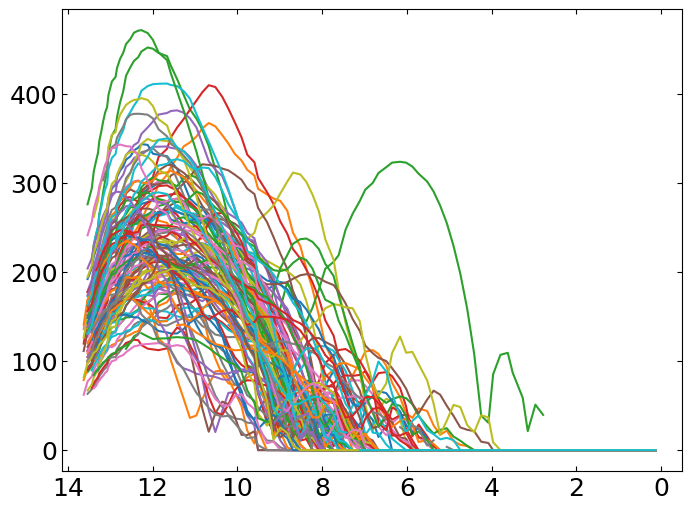

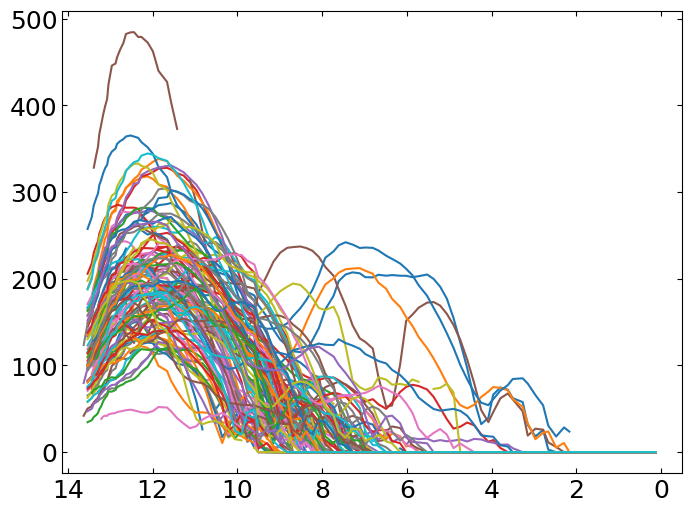

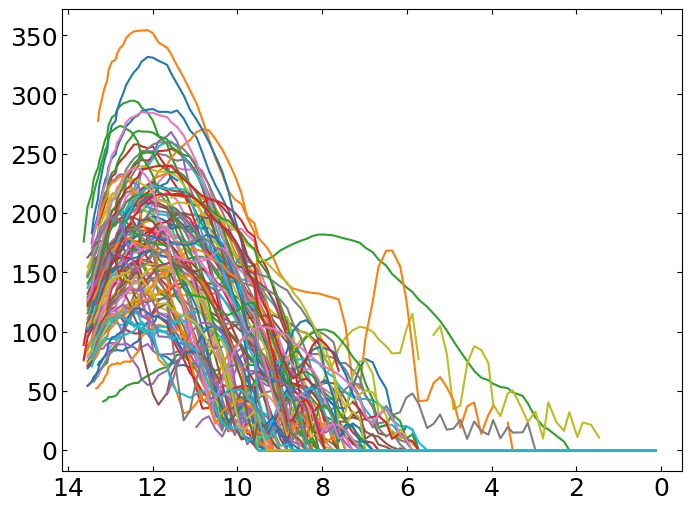

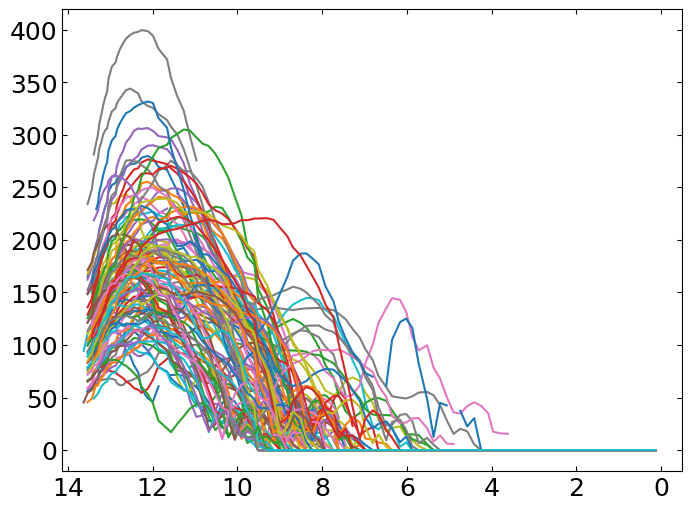

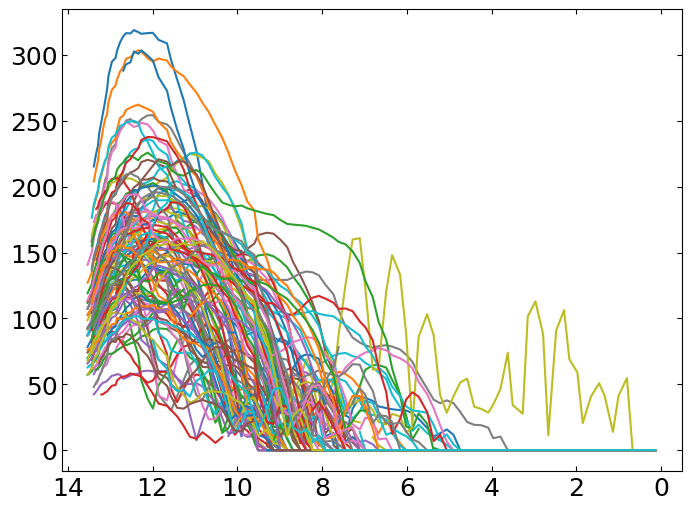

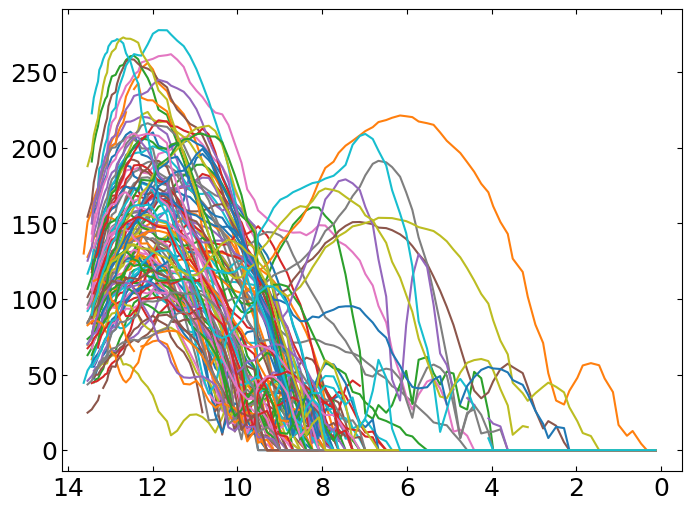

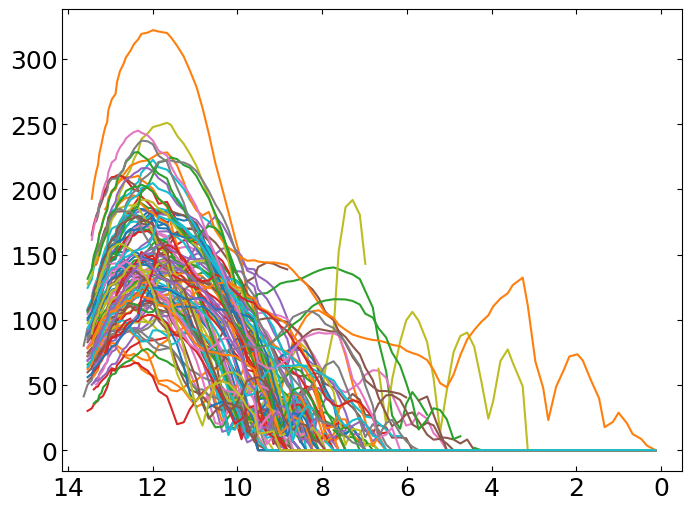

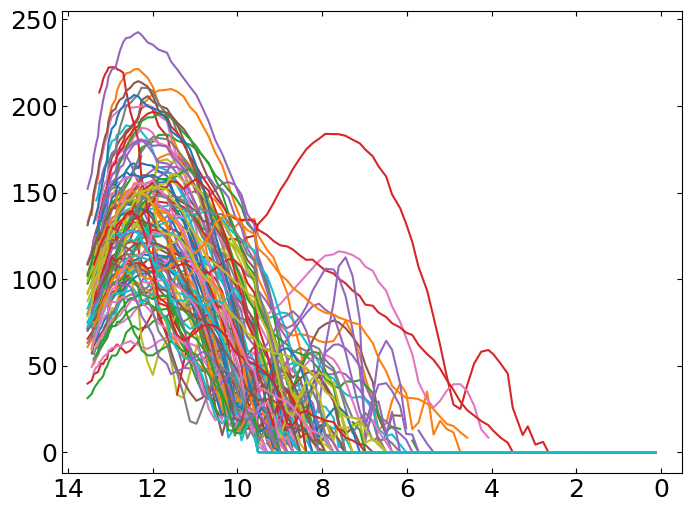

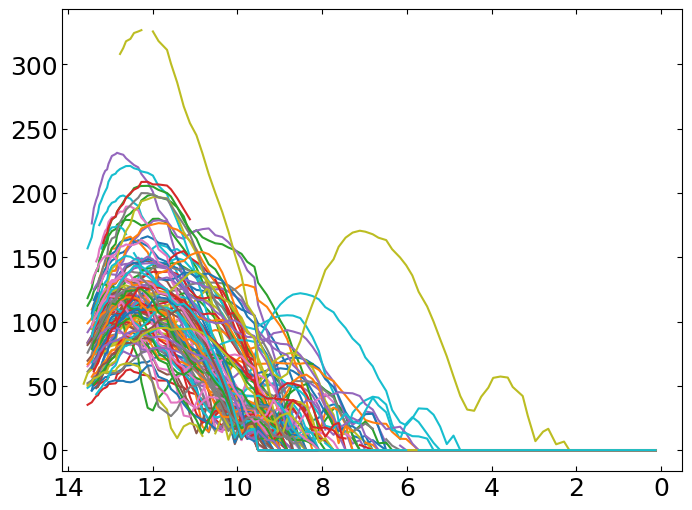

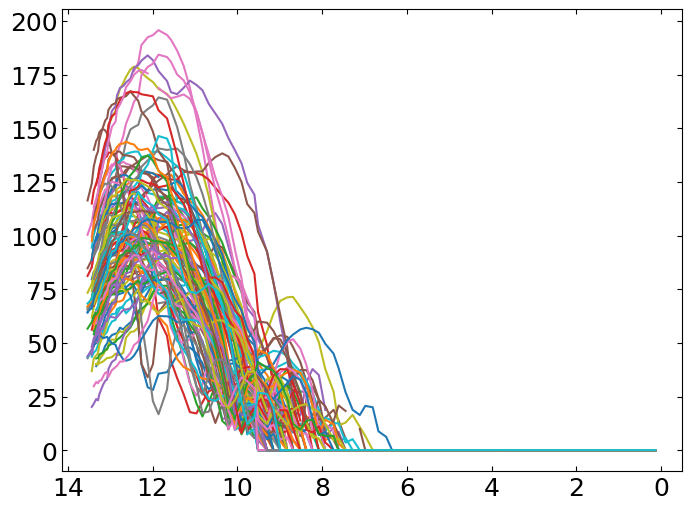

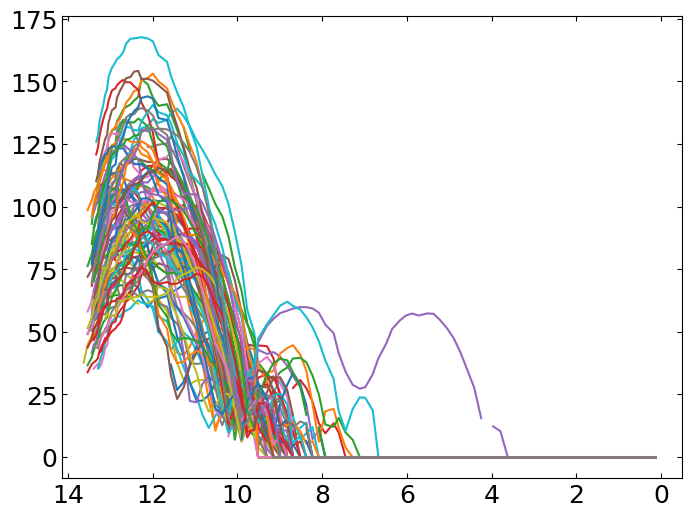

In [81]:

nummergers = len(check_dict['Separations'][mergers])
numnonmergers = len(check_dict['Separations'][nonmergers])

plotnum = 0
for i in range(nummergers):
    if plotnum%110 == 0:
        fig = plt.figure(figsize=(8,6))
    plotnum += 1
    plt.plot(snap_dict['Lookback Time'][::-1][1:],check_dict['Separations'][mergers][i])    
#     plt.legend()    
    plt.xlim(np.max(snap_dict['Lookback Time']+0.5),-0.5)
plt.show()


### Plots of pairs that don't merge

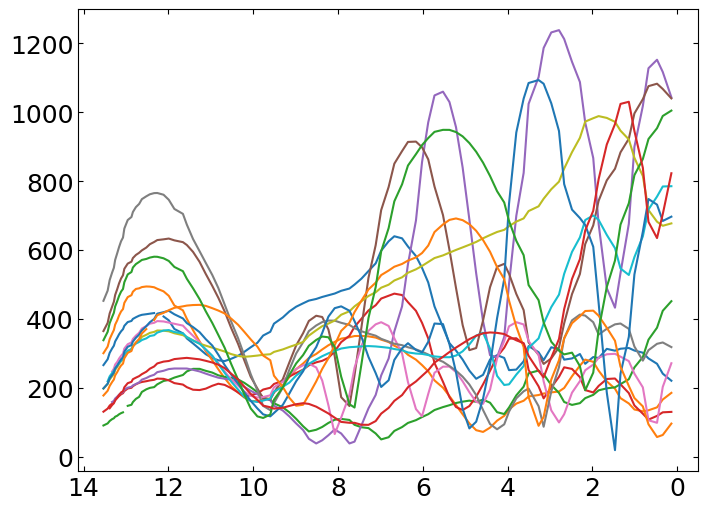

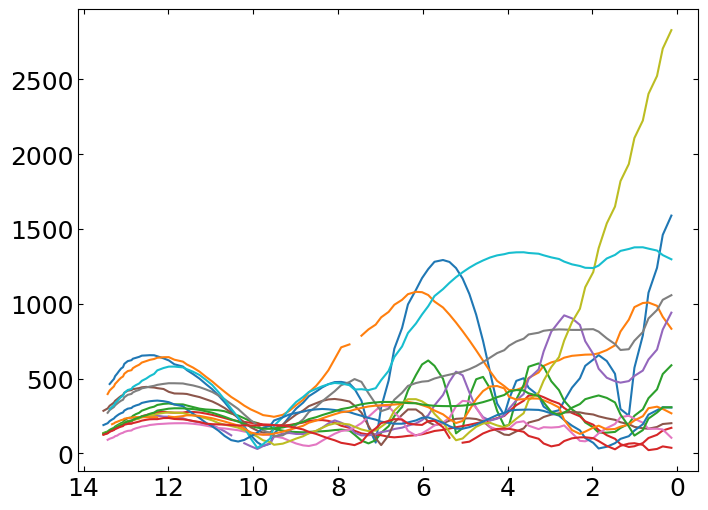

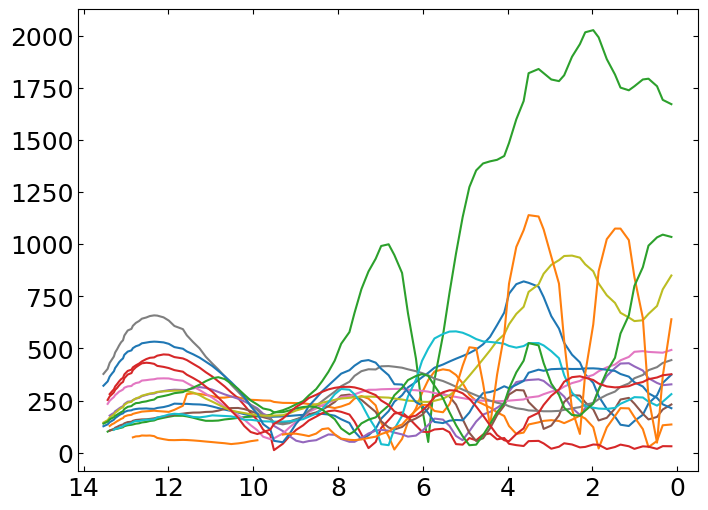

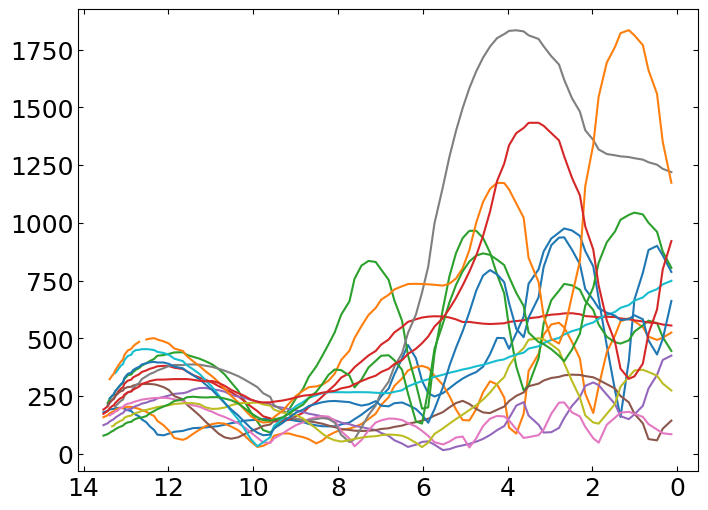

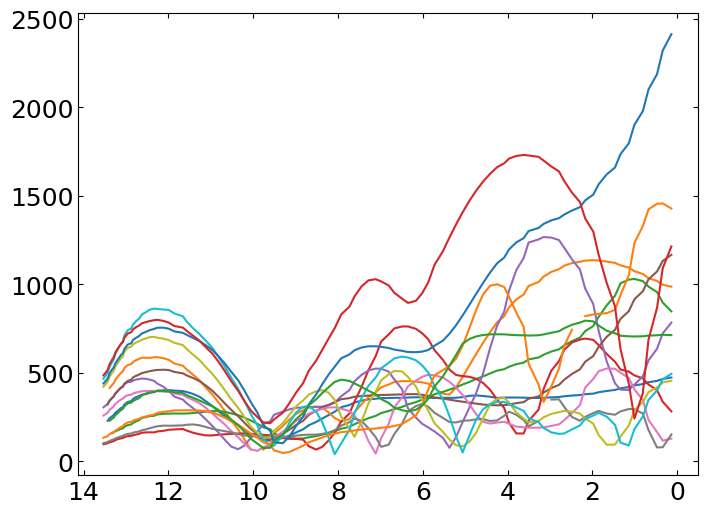

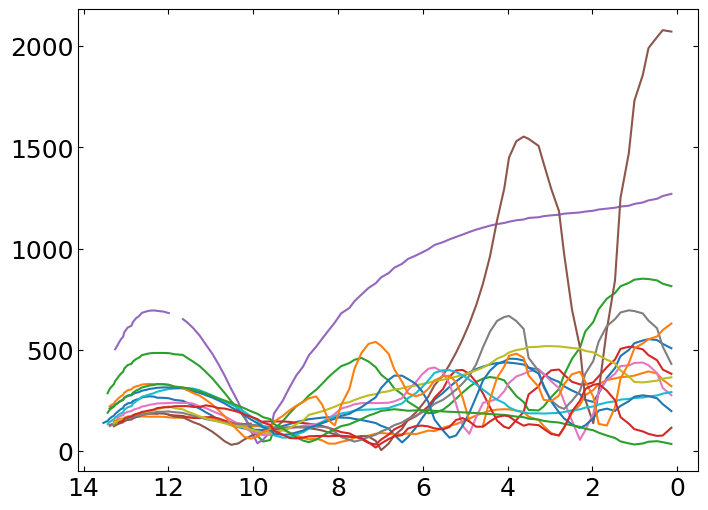

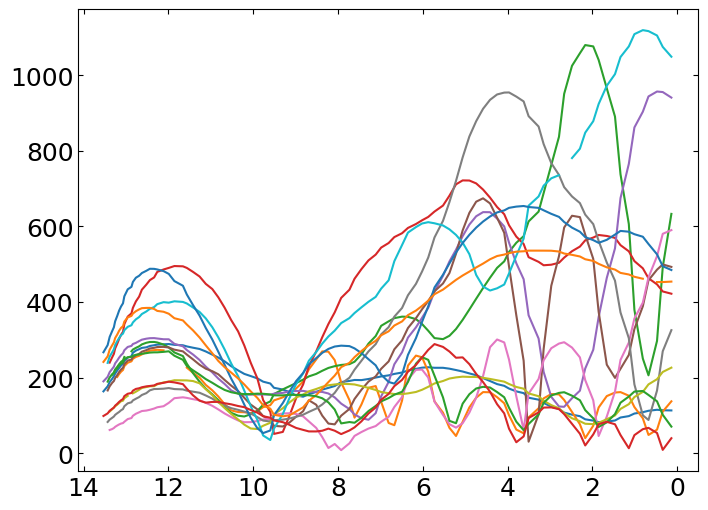

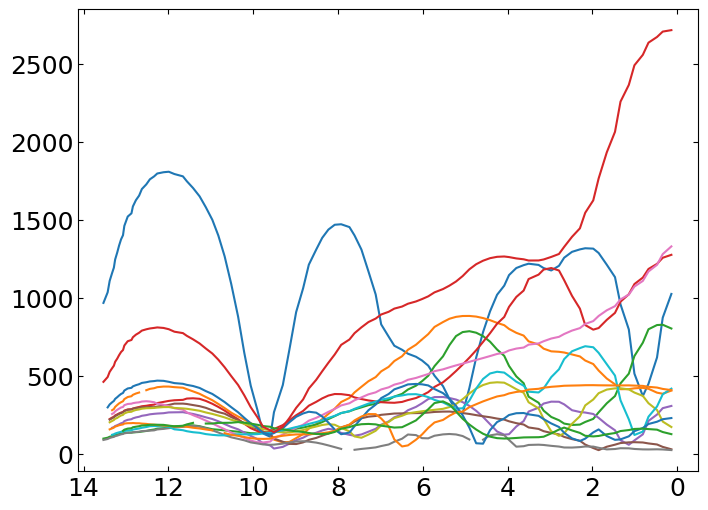

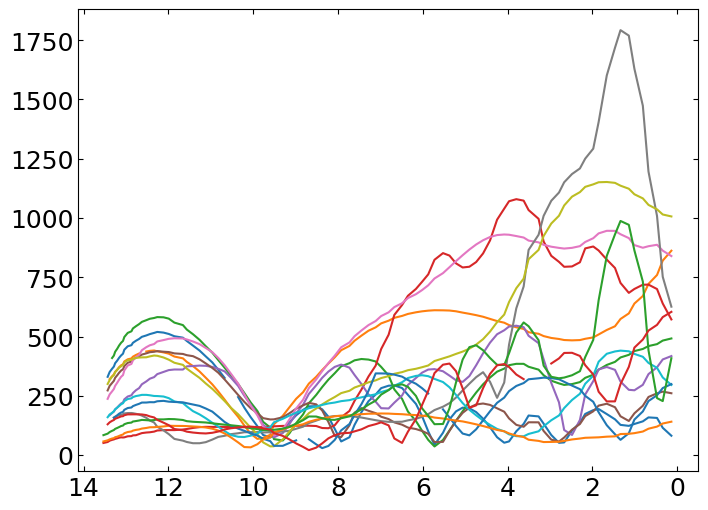

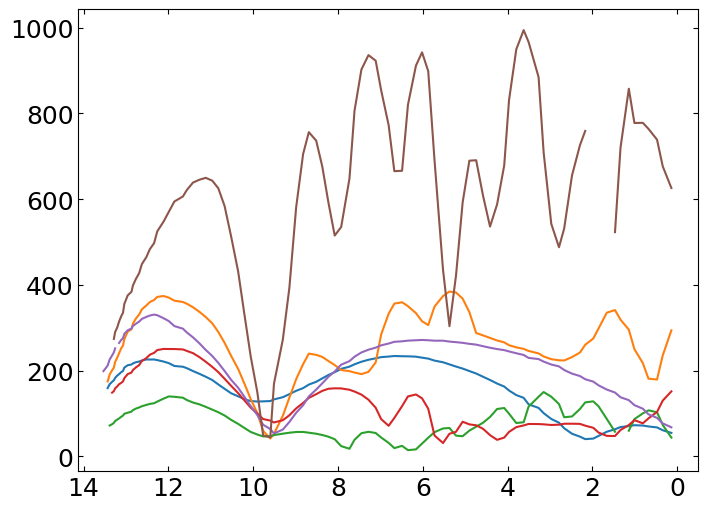

In [83]:

nummergers = len(check_dict['Separations'][mergers])
numnonmergers = len(check_dict['Separations'][nonmergers])

plotnum = 0
for i in range(numnonmergers):
    if plotnum%14 == 0:
        fig = plt.figure(figsize=(8,6))
    plotnum += 1
    plt.plot(snap_dict['Lookback Time'][::-1][1:],check_dict['Separations'][nonmergers][i])    
#     plt.legend()    
    plt.xlim(np.max(snap_dict['Lookback Time']+0.5),-0.5)
plt.show()


In [85]:
# getting locations of all mergers
samegroup = check_dict['GroupFlag']
# nonmergers = np.isnan(check_dict['MergerSnapshot'])
samegroup

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

#### Plots of pairs that don't merge - only when they are still in the same group

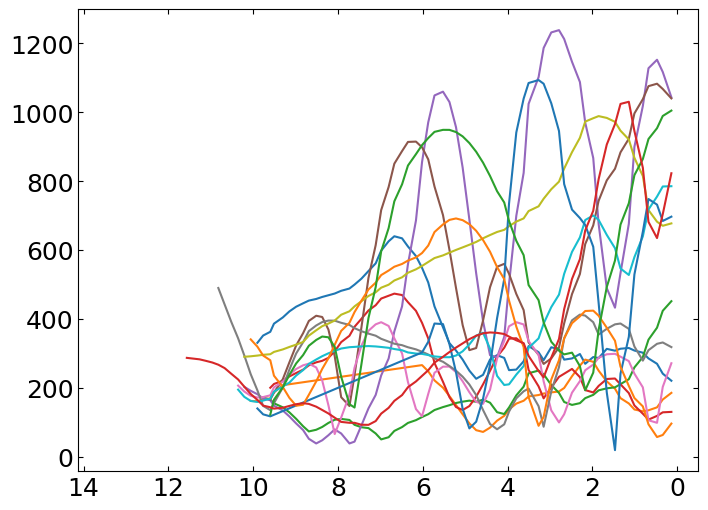

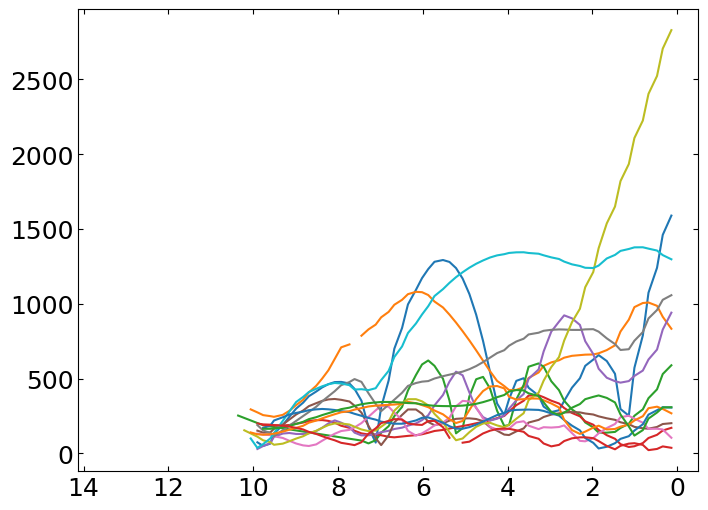

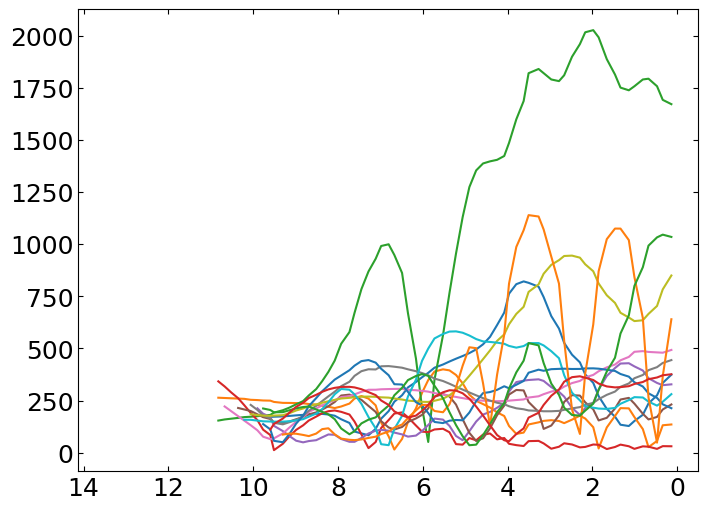

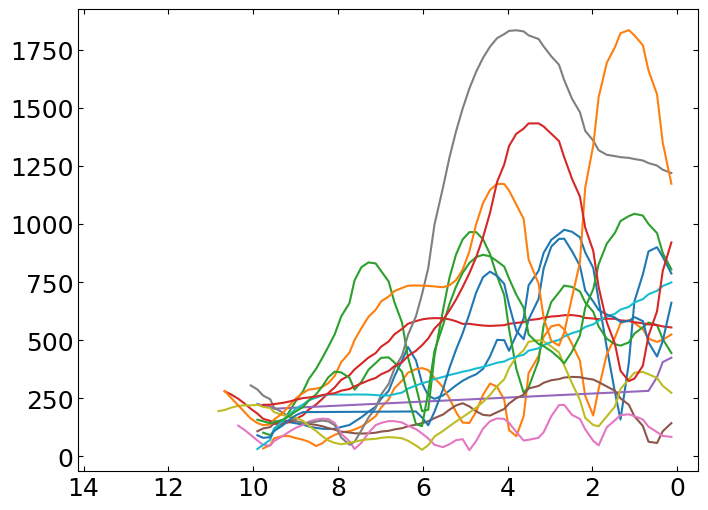

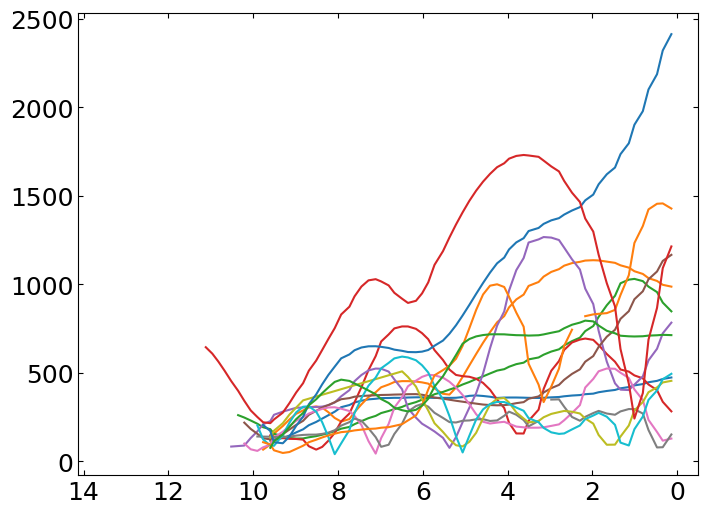

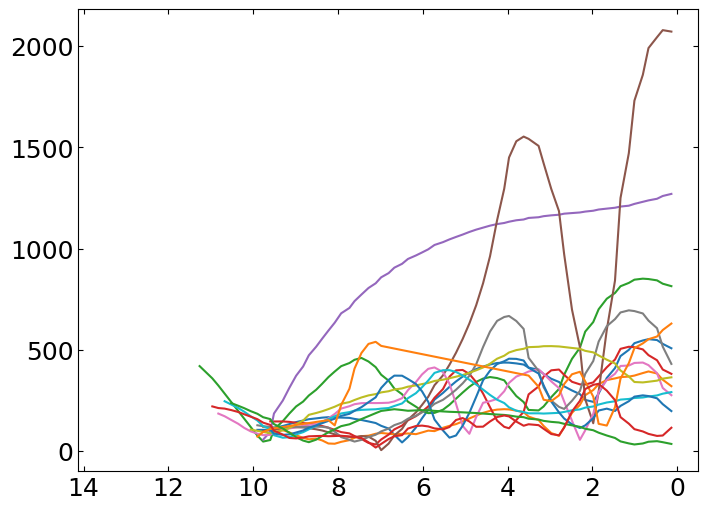

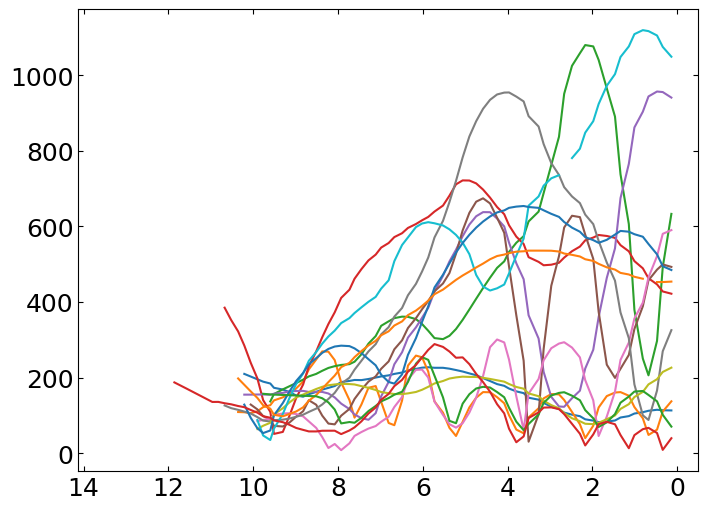

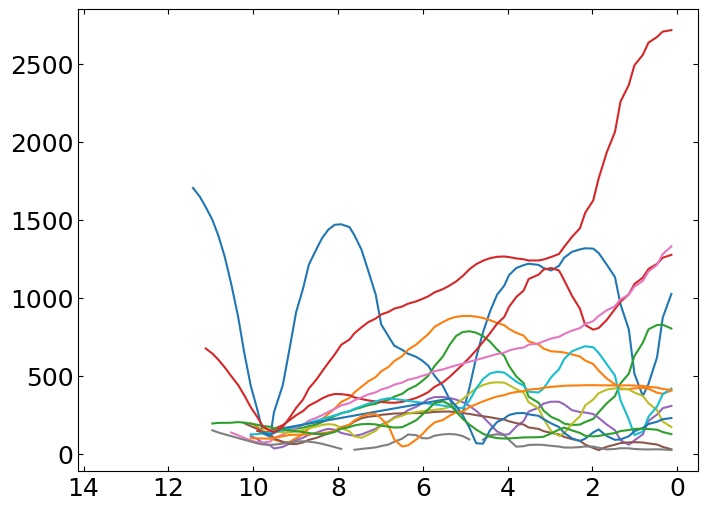

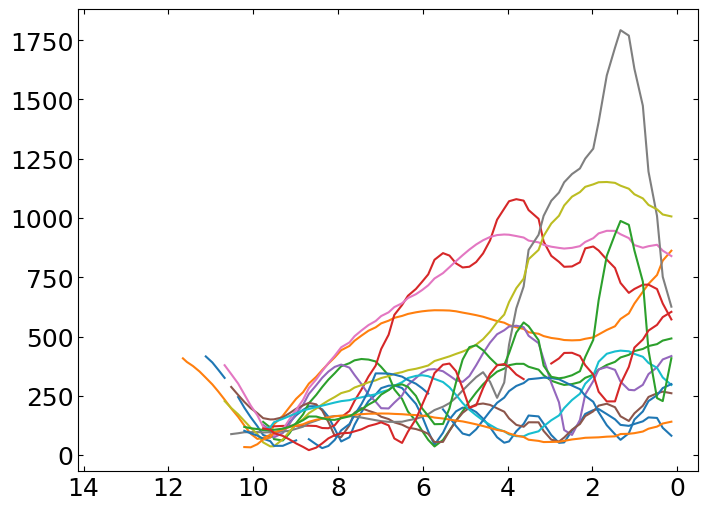

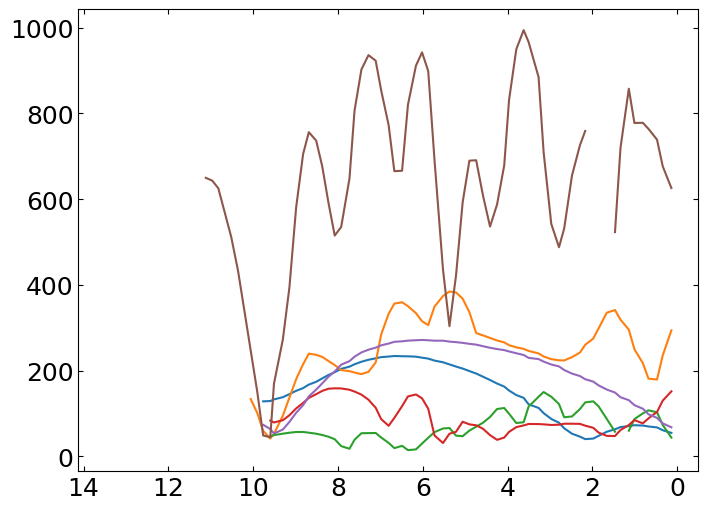

In [87]:
nummergers = len(check_dict['Separations'][mergers])
numnonmergers = len(check_dict['Separations'][nonmergers])

plotnum = 0
for i in range(numnonmergers):
    if plotnum%14 == 0:
        fig = plt.figure(figsize=(8,6))
    plotnum += 1
    plt.plot(snap_dict['Lookback Time'][::-1][1:][check_dict['GroupFlag'][i]],check_dict['Separations'][nonmergers][i][check_dict['GroupFlag'][i]])    
#     plt.legend()    
    plt.xlim(np.max(snap_dict['Lookback Time']+0.5),-0.5)
plt.show()


In [20]:
np.where(check_dict['MergerSnapshot']==np.NaN)

(array([], dtype=int64),)

In [49]:
len(snap_dict['Lookback Time'][1:])

99

In [37]:
print(len(check_dict['Separations'][mergers]))
print(len(check_dict['Separations'][nonmergers]))

1198
132


In [48]:
len(check_dict['Separations'][mergers][0])

99

In [71]:
snap_dict['Lookback Time'][::-1][1:]

array([ 0.13648833,  0.34007461,  0.47502133,  0.67625252,  0.80960087,
        1.0083923 ,  1.14008622,  1.33635449,  1.4663389 ,  1.66000232,
        1.85206448,  1.97920241,  2.16853359,  2.29382551,  2.48035043,
        2.66515681,  2.78739386,  2.96928046,  3.14938326,  3.26844946,
        3.50414693,  3.6207657 ,  3.79413961,  3.96563147,  4.07890482,
        4.24722031,  4.41360808,  4.57805312,  4.74054166,  4.90106113,
        5.0596002 ,  5.21614881,  5.37069816,  5.52324072,  5.7234985 ,
        5.87133643,  6.01715166,  6.16094216,  6.34951208,  6.48857728,
        6.6708518 ,  6.80520283,  6.98120678,  7.11086956,  7.28064697,
        7.4468931 ,  7.6096314 ,  7.7293989 ,  7.92469312,  8.07707784,
        8.22607695,  8.37172731,  8.51406791,  8.68740199,  8.82244839,
        8.98680396,  9.14629731,  9.30102237,  9.50981086,  9.59655574,
        9.76523678,  9.90101118, 10.0583425 , 10.2097357 , 10.35536972,
       10.51823531, 10.67378679, 10.82230287, 10.96405813, 11.11

In [68]:
snap_dict['Lookback Time'][::-1]

array([1.77635684e-15, 1.36488333e-01, 3.40074606e-01, 4.75021330e-01,
       6.76252517e-01, 8.09600867e-01, 1.00839230e+00, 1.14008622e+00,
       1.33635449e+00, 1.46633890e+00, 1.66000232e+00, 1.85206448e+00,
       1.97920241e+00, 2.16853359e+00, 2.29382551e+00, 2.48035043e+00,
       2.66515681e+00, 2.78739386e+00, 2.96928046e+00, 3.14938326e+00,
       3.26844946e+00, 3.50414693e+00, 3.62076570e+00, 3.79413961e+00,
       3.96563147e+00, 4.07890482e+00, 4.24722031e+00, 4.41360808e+00,
       4.57805312e+00, 4.74054166e+00, 4.90106113e+00, 5.05960020e+00,
       5.21614881e+00, 5.37069816e+00, 5.52324072e+00, 5.72349850e+00,
       5.87133643e+00, 6.01715166e+00, 6.16094216e+00, 6.34951208e+00,
       6.48857728e+00, 6.67085180e+00, 6.80520283e+00, 6.98120678e+00,
       7.11086956e+00, 7.28064697e+00, 7.44689310e+00, 7.60963140e+00,
       7.72939890e+00, 7.92469312e+00, 8.07707784e+00, 8.22607695e+00,
       8.37172731e+00, 8.51406791e+00, 8.68740199e+00, 8.82244839e+00,
      

In [ ]:
snap_dict[''][::-1]